In [52]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb

%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [53]:
import numpy as np 

def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(0, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true

In [54]:
def gini(solution, submission):
    df = zip(solution, submission)
    df = sorted(df, key=lambda x: (x[1],x[0]), reverse=True)
    rand = [float(i+1)/float(len(df)) for i in range(len(df))]
    totalPos = float(sum([x[0] for x in df]))
    cumPosFound = [df[0][0]]
    for i in range(1,len(df)):
        cumPosFound.append(cumPosFound[len(cumPosFound)-1] + df[i][0])
    Lorentz = [float(x)/totalPos for x in cumPosFound]
    Gini = [Lorentz[i]-rand[i] for i in range(len(df))]
    return sum(Gini)

def normalized_gini(solution, submission):
    solution=np.array(solution)
    submission=np.array(submission)
    normalized_gini = gini(solution, submission)/gini(solution, solution)
    return normalized_gini

In [55]:
def xgboost_pred(train,labels,test):
    params = {}
    params["objective"] = "reg:linear"
    params["eta"] = 0.005
    params["min_child_weight"] = 6
    params["subsample"] = 0.7
    params["colsample_bytree"] = 0.7
    params["scale_pos_weight"] = 1
    params["silent"] = 1
    params["max_depth"] = 9


    plst = list(params.items())

    #Using 5000 rows for early stopping. 
    offset = 4000

    num_rounds = 11000
    xgtest = xgb.DMatrix(test)

    #create a train and validation dmatrices 
    xgtrain = xgb.DMatrix(train[offset:,:], label=labels[offset:])
    xgval = xgb.DMatrix(train[:offset,:], label=labels[:offset])

    #train using early stopping and predict
    watchlist = [(xgtrain, 'train'),(xgval, 'val')]
    model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=120)
    preds1 = model.predict(xgtest,ntree_limit=model.best_iteration)

#     importance_matrix = xgb.importance(names, model = bst)

    #reverse train and labels and use different 5k for early stopping. 
    # this adds very little to the score but it is an option if you are concerned about using all the data. 
    train = train[::-1,:]
    labels = np.log(labels[::-1])

    xgtrain = xgb.DMatrix(train[offset:,:], label=labels[offset:])
    xgval = xgb.DMatrix(train[:offset,:], label=labels[:offset])

    watchlist = [(xgtrain, 'train'),(xgval, 'val')]
    model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=120)
    preds2 = model.predict(xgtest,ntree_limit=model.best_iteration)

    print "Normalized gini is: {0}".format(normalized_gini(labels, model.predict(xgb.DMatrix(train))))
    #since the metric only cares about relative rank we don't need to average
    preds = (preds1)*1.4 + (preds2)*8.6
    return preds

In [56]:
#load train and test 
train  = pd.read_csv('../data/train.csv', index_col=0)
test  = pd.read_csv('../data/test.csv', index_col=0)


labels = train.Hazard
train.drop('Hazard', axis=1, inplace=True)

train_s = train
test_s = test


train_s.drop('T2_V10', axis=1, inplace=True)
train_s.drop('T2_V7', axis=1, inplace=True)
train_s.drop('T1_V13', axis=1, inplace=True)
train_s.drop('T1_V10', axis=1, inplace=True)

test_s.drop('T2_V10', axis=1, inplace=True)
test_s.drop('T2_V7', axis=1, inplace=True)
test_s.drop('T1_V13', axis=1, inplace=True)
test_s.drop('T1_V10', axis=1, inplace=True)

columns = train.columns
test_ind = test.index


train_s = np.array(train_s)
test_s = np.array(test_s)

# label encode the categorical variables
for i in range(train_s.shape[1]):
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_s[:,i]) + list(test_s[:,i]))
    train_s[:,i] = lbl.transform(train_s[:,i])
    test_s[:,i] = lbl.transform(test_s[:,i])

train_s = train_s.astype(float)
test_s = test_s.astype(float)


preds1 = xgboost_pred(train_s,labels,test_s)

#model_2 building

train = train.T.to_dict().values()
test = test.T.to_dict().values()

vec = DictVectorizer()
train = vec.fit_transform(train)
test = vec.transform(test)

preds2 = xgboost_pred(train,labels,test)

preds = 0.47 * (preds1**0.0455) + 0.53 * (preds2**0.55)

#generate solution
preds = pd.DataFrame({"Id": test_ind, "Hazard": preds})
preds = preds.set_index('Id')
preds.to_csv('../ensemble/xgboost_benchmark.csv')

Will train until val error hasn't decreased in 120 rounds.
[0]	train-rmse:5.336714	val-rmse:5.284147
[1]	train-rmse:5.323473	val-rmse:5.271461
[2]	train-rmse:5.310524	val-rmse:5.259053
[3]	train-rmse:5.297418	val-rmse:5.246769
[4]	train-rmse:5.284426	val-rmse:5.234604
[5]	train-rmse:5.271632	val-rmse:5.222144
[6]	train-rmse:5.258730	val-rmse:5.210096
[7]	train-rmse:5.246202	val-rmse:5.198252
[8]	train-rmse:5.233754	val-rmse:5.186273
[9]	train-rmse:5.221134	val-rmse:5.174460
[10]	train-rmse:5.208577	val-rmse:5.162656
[11]	train-rmse:5.196361	val-rmse:5.151114
[12]	train-rmse:5.183791	val-rmse:5.139320
[13]	train-rmse:5.171946	val-rmse:5.128232
[14]	train-rmse:5.159870	val-rmse:5.116938
[15]	train-rmse:5.148036	val-rmse:5.105683
[16]	train-rmse:5.136128	val-rmse:5.094556
[17]	train-rmse:5.124446	val-rmse:5.083549
[18]	train-rmse:5.112705	val-rmse:5.072504
[19]	train-rmse:5.101013	val-rmse:5.061572
[20]	train-rmse:5.089286	val-rmse:5.050776
[21]	train-rmse:5.077683	val-rmse:5.039927
[22]	

Normalized gini is: 0.661065525989
Normalized gini is: 0.629045831146


[1686]	train-rmse:0.728529	val-rmse:0.847463
Stopping. Best iteration:
[1566]	train-rmse:0.734793	val-rmse:0.847318



NameError: name 'model' is not defined

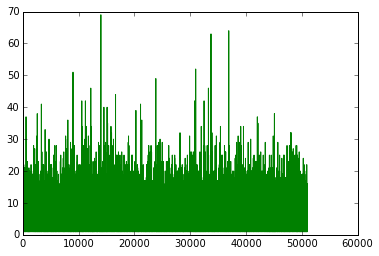

In [57]:
# Plot predicted and true interarrival times on the training set

plt.plot(labels, color="green", label="True value")
# plt.plot(model.predict(xgb.DMatrix(train)), label="Predicted value")

plt.xlabel("Record number", fontsize=14)
plt.ylabel("Hazard rating", fontsize=14)
plt.legend(frameon=True, shadow=True, framealpha=0.7, loc=0, prop={"size": 14})

In [58]:
preds_new
# preds_new = preds["Hazard"].drop([101997],axis=0)

Id
6         2.512264
7         3.292175
8         3.614534
9         2.698999
10        2.276515
11        2.751098
13        3.035220
14        2.243684
16        2.521708
17        2.450141
18        3.092810
20        2.580127
27        3.692892
28        3.015311
29        2.295506
30        2.522317
34        2.495373
35        2.802149
36        2.702730
37        2.630957
38        2.536193
40        2.546559
42        2.929181
46        2.646770
47        2.752434
48        2.991056
49        3.548767
51        3.102942
52        3.076563
53        1.873432
            ...   
101950    2.442551
101951    2.888292
101952    2.896927
101954    2.046144
101955    3.143399
101956    2.962272
101957    2.916617
101958    2.335093
101960    2.991688
101961    3.000591
101963    2.174620
101964    2.810384
101965    2.740389
101966    2.146429
101967    3.066333
101969    3.170845
101970    2.744542
101972    2.713968
101973    3.102373
101974    2.693135
101976    3.083030
101977   

In [59]:
train  = pd.read_csv('../data/train.csv', index_col=0)
labels = train.Hazard

In [60]:
labels

Id
1          1
2          4
3          1
4          1
5          1
12         1
15         5
19         1
21         1
22         1
23         7
24        15
25         1
26         4
31        14
32         1
33         1
39         1
41         4
43         1
44         4
45         4
50         8
58        16
59         5
62         1
63         6
67         7
69         1
72         1
          ..
101929     1
101931     4
101933     2
101935     1
101937    14
101939     5
101942     4
101943     2
101944     4
101945     6
101946     9
101953     1
101959     1
101962     5
101968     1
101971     1
101975     1
101978    14
101980     3
101981     1
101984     2
101986    16
101987    12
101988     4
101991     1
101992     7
101993     4
101994     3
101998    14
101999     9
Name: Hazard, dtype: int64

In [61]:

Gini(labels, preds_new)

-0.0062793744937390227

In [ ]:
test_ind

-0.0062793744937390227